In [61]:
import h5py
import torch
import torch.nn as nn
import random


import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tempfile import TemporaryFile
from scipy.io import loadmat
# import skfuzzy as fuzz

In [62]:
from torch.utils.data import DataLoader, TensorDataset

In [63]:
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
print(FILE_PATH)

/home/thien/Hprediction/H_est_cGAN/Channel_Estimation_cGAN/Torch_code


In [64]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [65]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 20


In [66]:
# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['550', '568']] # , ['5100','5109']

In [67]:
# file path
outer_file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Static_612x14', 'freq_symb_1ant_612sub')

H_true = np.empty((0, 2, 612, 14)) # true channel

H_equal = np.empty((0, 2, 612, 14)) # noisy channel # LS channel
H_linear = np.empty((0, 2, 612, 14)) # noisy channel # LS+Linear Interpolated channel
H_practical = np.empty((0, 2, 612, 14)) # noisy channel # Practical Estimated channel

# read data from ifferent .mat file, then concatenate them
for i in range(len(rows)):
    file_path_partial = 'Gan_0_dBOutdoor1_60_1ant_612subcs_Row_' + rows[i][0] +'_' + rows[i][1] + '.mat'

    file_path = os.path.join(outer_file_path, file_path_partial)
    file_path = os.path.normpath(file_path)
    file = h5py.File(file_path, 'r')
    
    H_true = np.concatenate((H_true, np.array(file['H_data'])), axis = 0) # N_samples x channel(2) x height(614) x width(14)
    H_equal = np.concatenate((H_equal, np.array(file['H_equalized_data'])), axis = 0)
    H_linear = np.concatenate((H_linear, np.array(file['H_linear_data'])), axis=0)
    H_practical = np.concatenate((H_practical, np.array(file['H_practical_data'])), axis=0)

H_true.shape

(3439, 2, 612, 14)

In [68]:
shuffle_order = np.random.permutation(H_true.shape[0]);
H_true = torch.tensor(H_true[shuffle_order])
H_equal = torch.tensor(H_equal[shuffle_order])
H_linear = torch.tensor(H_linear[shuffle_order])
H_practical = torch.tensor(H_practical[shuffle_order])
H_true.shape
# Hreal = torch.tensor(Hreal)     
# input_data = torch.tensor(input_data)     

torch.Size([3439, 2, 612, 14])

In [69]:
# read data from 1 single .mat file

# Constants
# file_path = os.path.join(FILE_PATH, '..', 'DeepMIMOv2', 'Gan_Data', 'Static_612x14', 'freq_symb_1ant_612sub', 'Gan_0_dBOutdoor1_60_1ant_612subcs.mat')

# file_path = os.path.normpath(file_path)

# file = h5py.File(file_path, 'r')

# # pytorch: [batchsize, channels, height, width]

# Hreal = np.array(file['H_data']) # N_samples x channel(2) x height(614) x width(14)
# Hreal = torch.tensor(Hreal) 
# #
# input_data = np.array(file['H_linear_data'])
# input_data = torch.tensor(input_data)             

# input_data.shape

In [70]:
train_size = np.floor(H_practical.shape[0]*0.9) //BATCH_SIZE *BATCH_SIZE
# print(train_size)
# print(train_size/64)
# print(train_size/input_data.size(0))
train_size = int(train_size)

In [71]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_linear[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

# Split H_equal, H_linear, H_practical for validation later
H_equal_val = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
H_linear_val = H_linear[train_size:,:,:,:].to(device, dtype=torch.float)
H_practical_val = H_practical[train_size:,:,:,:].to(device, dtype=torch.float)

In [72]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
# for evaluation, output of model(valData) will be de-normalized and compared with valLabels

print(valData_normd.shape)
print(trainData_normd.shape)

torch.Size([367, 2, 612, 14])
torch.Size([3072, 2, 612, 14])


In [73]:
# Doppler_phase = exp(-1j*2*pi*params.carrier_freq*( ((path_params.Doppler_vel.*delay)./physconst('LightSpeed')) + ((path_params.Doppler_acc.*(delay.^2))./(2*physconst('LightSpeed'))) ));

In [74]:
plot = 0
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [75]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)

trainData_normd.shape

torch.Size([6144, 1, 612, 14])

In [76]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [77]:
# Validate roughly 5 times every epoch
valFrequency = round(trainData_normd.size(0)/BATCH_SIZE/5); 

In [78]:
class CNN_Est(nn.Module):
    def __init__(self):
        super(CNN_Est, self).__init__()
        
        self.normalization = nn.BatchNorm2d(1)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.relu  = nn.ReLU() 
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        # Forward pass
        out = self.normalization(x)
        out = self.conv1(x)
        out = self.relu(out)  
        out = self.conv2(out)
        out = self.relu(out)  
        out = self.conv3(out)
        out = self.relu(out)  
        out = self.conv4(out)
        out = self.relu(out) 
        out = self.conv5(out)
        return out

In [79]:
model = CNN_Est().to(device)
print(model)

CNN_Est(
  (normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [80]:
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [81]:
# Training loop
train_loss =[]
vali_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    vali_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")


Epoch 1/20, Loss: 0.2826667220021288 
 Val Loss: 0.2692979859809081
Epoch 2/20, Loss: 0.23373818350955844 
 Val Loss: 0.18989107136925062
Epoch 3/20, Loss: 0.12473918051303674 
 Val Loss: 0.06814875236401956
Epoch 4/20, Loss: 0.04820520917807395 
 Val Loss: 0.04433624818921089
Epoch 5/20, Loss: 0.04113645917580774 
 Val Loss: 0.04134081304073334
Epoch 6/20, Loss: 0.03811328683514148 
 Val Loss: 0.038240015196303524
Epoch 7/20, Loss: 0.03498052996777309 
 Val Loss: 0.03501791491483649
Epoch 8/20, Loss: 0.03168881942595666 
 Val Loss: 0.03164000064134598
Epoch 9/20, Loss: 0.028277529558787744 
 Val Loss: 0.02819127744684617
Epoch 10/20, Loss: 0.024892716387209173 
 Val Loss: 0.024849290571485955
Epoch 11/20, Loss: 0.02175433838177317 
 Val Loss: 0.021933476052557428
Epoch 12/20, Loss: 0.01912186089612078 
 Val Loss: 0.019526921212673187
Epoch 13/20, Loss: 0.017121432446098577 
 Val Loss: 0.01791721923897664
Epoch 14/20, Loss: 0.015956685548493017 
 Val Loss: 0.017044129975450534
Epoch 15

In [82]:
H_NN_val.shape

torch.Size([367, 2, 612, 14])

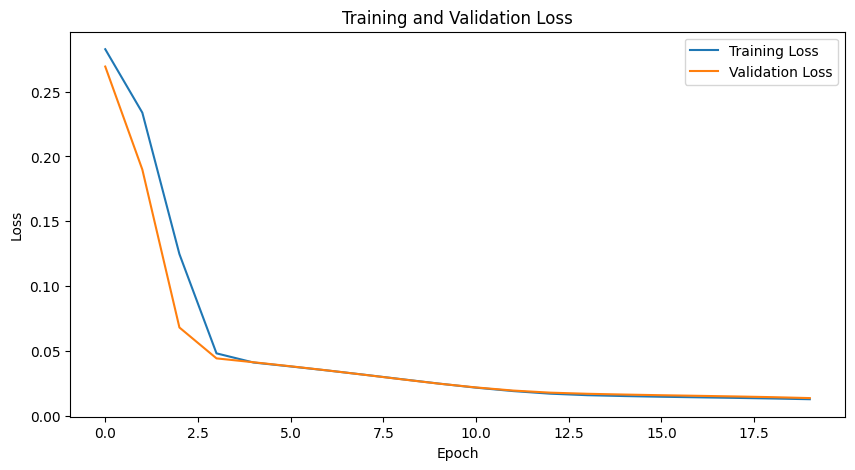

In [83]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

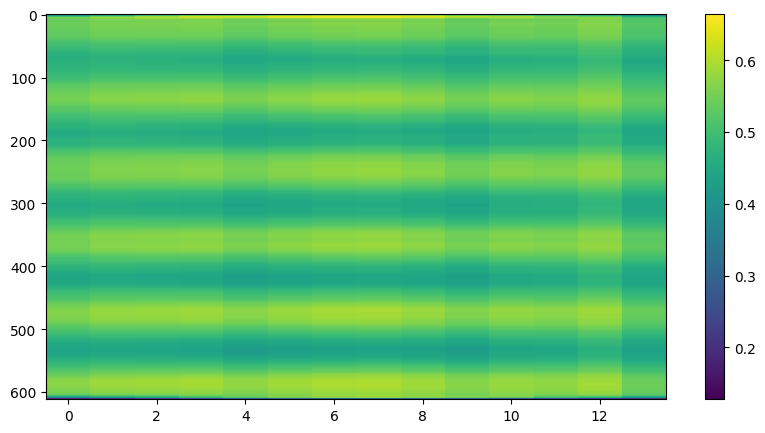

In [84]:
H_val_NN = H_NN_val.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

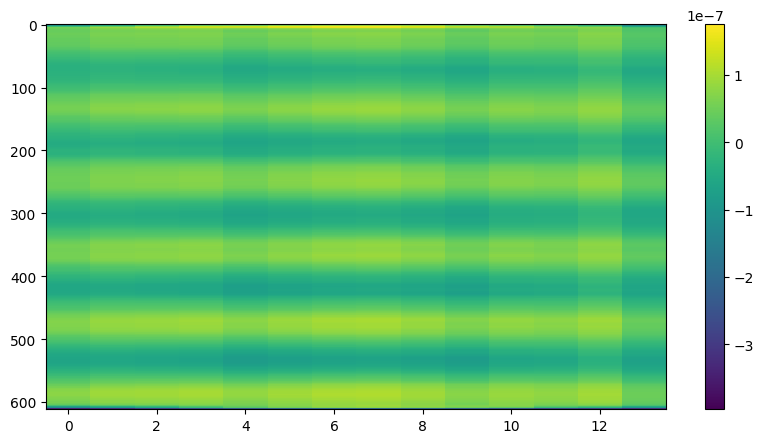

In [85]:
# De-normalized
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_NN_denormd[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

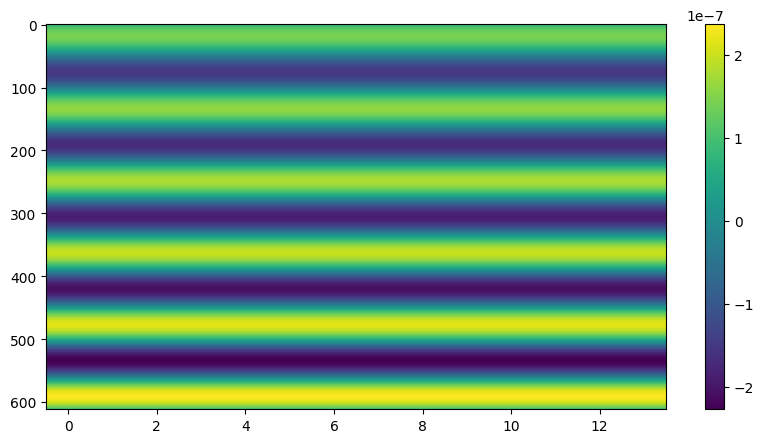

In [86]:
# True channel
H_val_true = valLabels.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_true[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

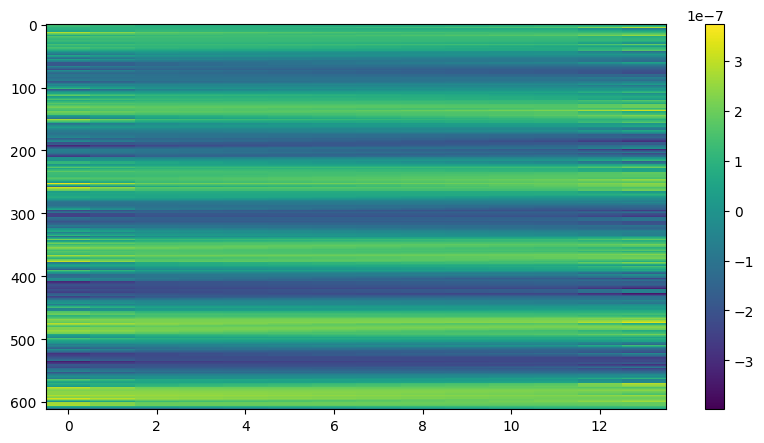

In [87]:
# Linear interpolated channel
H_val_linInterp = valData.cpu()
plt.figure(figsize=(10, 5))
plt.imshow(H_val_linInterp[-1,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
plt.colorbar()
plt.show()

In [88]:
H_val_true.shape

torch.Size([367, 2, 612, 14])

In [89]:
# draw flow chart
# convert H to complex 
# check nmse formula in papers
# nmse vs SNR 
# try with GAN

In [90]:
# convert to complex matrices
H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:])
H_val_NN_denormd_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])

In [91]:
H_val_true_complex[1,1,1]

tensor(6.9288e-08+1.9832e-07j)

In [92]:
H_val_true_complex.shape

torch.Size([367, 612, 14])

In [93]:
# NMSE of Linear Interpolation
# Calculate the mean squared error
mse_LI = torch.mean(torch.abs(H_val_true_complex - H_val_linInterp_complex) ** 2)
# Calculate the variance of the reference tensor (complex_tensor1)
variance = torch.var(H_val_true_complex)
# Calculate the NMSE
nmse_LI = mse_LI / variance
print(f"NMSE: {nmse_LI.item()}")

NMSE: 0.08237994462251663


In [94]:
# NMSE of Linear Interpolation + NN
# Calculate the mean squared error
mse_LI_NN = torch.mean(torch.abs(H_val_true_complex - H_val_NN_denormd_complex) ** 2)
# Calculate the NMSE
nmse_LI_NN = mse_LI_NN / variance
print(f"NMSE: {nmse_LI_NN.item()}")

NMSE: 0.4842628836631775


When Input of the NN is just H_equalized

In [95]:
# [samples, 2, 612, 14]
# Split into training and validation sets for H_NN training
trainData   = H_equal[0:train_size,:,:,:].to(device, dtype=torch.float)
trainLabels = H_true[0:train_size,:,:,:].to(device, dtype=torch.float)

valData   = H_equal[train_size:,:,:,:].to(device, dtype=torch.float)
valLabels = H_true[train_size:,:,:,:].to(device, dtype=torch.float)

In [96]:
# Normalization
trainData_min = trainData.min()
trainData_max = trainData.max()
trainLabels_min = trainLabels.min()
trainLabels_max = trainLabels.max()

trainData_normd   = (trainData - trainData_min)/ (trainData_max - trainData_min)
trainLabels_normd = (trainLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)
valData_normd     = (valData - trainData_min)/ (trainData_max - trainData_min)
valLabels_normd   = (valLabels - trainLabels_min)/ (trainLabels_max - trainLabels_min)


In [97]:
# Split real and imaginary grids into 2 image sets, then concatenate
trainData_normd   = torch.cat((trainData_normd[:,0,:,:], trainData_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)
trainLabels_normd = torch.cat((trainLabels_normd[:,0,:,:], trainLabels_normd[:,1,:,:]), dim=0).unsqueeze(1)  # 612 x 14 x (Nsamples*2)


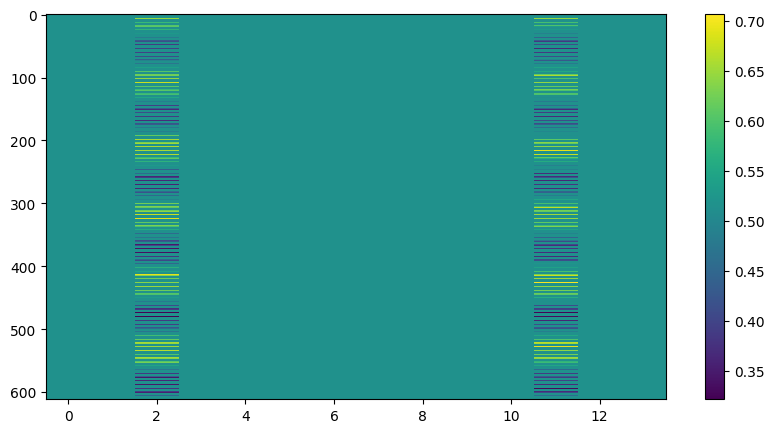

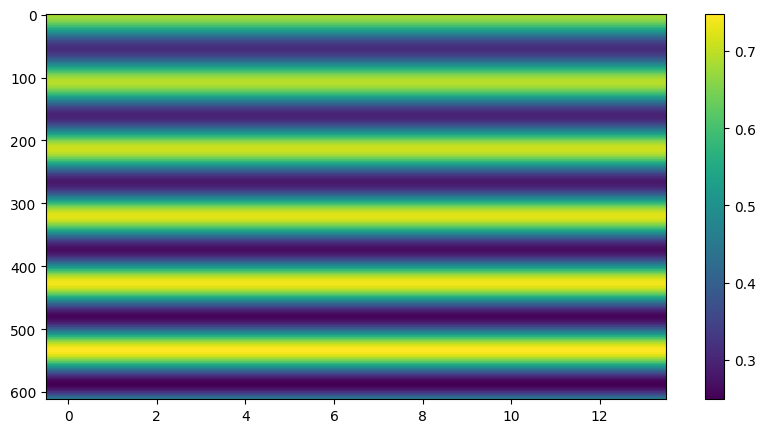

In [98]:
plot = 1
if plot:
    H_temp = trainData_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

    H_temp = trainLabels_normd.cpu()
    plt.figure(figsize=(10, 5))
    plt.imshow(H_temp[0,0,:,:],  aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar()
    plt.show()

In [99]:
# Create a DataLoader for your dataset
dataset = TensorDataset(trainData_normd, trainLabels_normd)  # [4224, 1, 612, 14]
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(valData_normd, valLabels_normd)  # [241, 2, 612, 14]
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [100]:
model2 = CNN_Est().to(device)
learning_rate = 0.00001
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate) 
criterion = nn.MSELoss()

In [101]:
# Training loop
train_loss =[]
vali_loss = []
H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
num_epochs = NUM_EPOCHS
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    if (epoch == num_epochs-1):
        i = 0
    for inputs, targets in train_loader:
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(train_loader)
    train_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
    
    # Validation 
    model2.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
            val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
            val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
            val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
            
            val_outputs_real = model2(val_inputs_real)
            val_loss_real = criterion(val_outputs_real, val_targets_real)
            running_val_loss += val_loss_real.item()
            
            val_outputs_imag = model2(val_inputs_imag)
            val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
            running_val_loss += val_loss_imag.item()
            
            if (epoch == num_epochs-1):
                H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                i = i+val_outputs_imag.size(0)
            
    avg_val_loss = running_val_loss / (len(val_loader)*2)
    vali_loss.append(avg_val_loss)    
            
    print(f" Val Loss: {avg_val_loss}")

Epoch 1/20, Loss: 0.0942146592521264 
 Val Loss: 0.036621106478075184
Epoch 2/20, Loss: 0.026945683047718678 
 Val Loss: 0.025474361376836896
Epoch 3/20, Loss: 0.021003800104760256 
 Val Loss: 0.019302392999331158
Epoch 4/20, Loss: 0.009480567257317793 
 Val Loss: 0.0022012256134379036
Epoch 5/20, Loss: 0.001180934815844618 
 Val Loss: 0.0010372651837921392
Epoch 6/20, Loss: 0.0008496423191293919 
 Val Loss: 0.0008344973757630214
Epoch 7/20, Loss: 0.0007012803491003675 
 Val Loss: 0.0007243395618085439
Epoch 8/20, Loss: 0.0006059202331319588 
 Val Loss: 0.0006186817796939673
Epoch 9/20, Loss: 0.0005301911372346998 
 Val Loss: 0.0005368144423603857
Epoch 10/20, Loss: 0.00046377966600630316 
 Val Loss: 0.00048388485083705746
Epoch 11/20, Loss: 0.00042821379353578476 
 Val Loss: 0.00045066769477368024
Epoch 12/20, Loss: 0.00040784487176400336 
 Val Loss: 0.00043455268557105836
Epoch 13/20, Loss: 0.0003906728143192595 
 Val Loss: 0.000418822802506232
Epoch 14/20, Loss: 0.000383289484489068

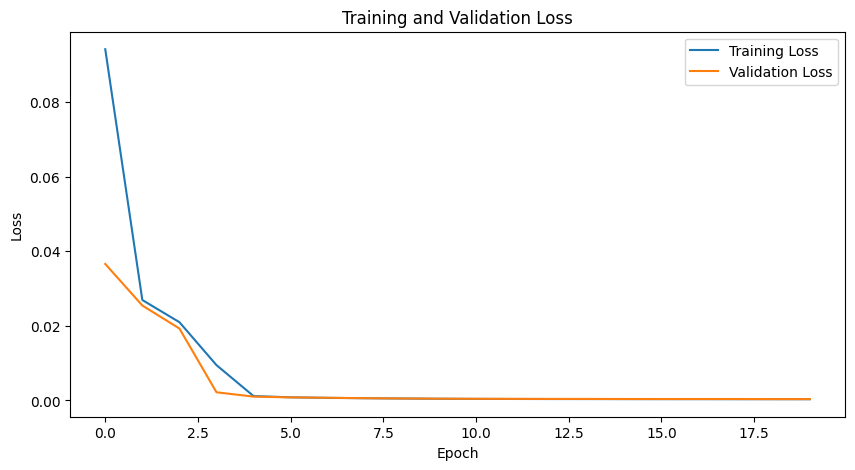

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(vali_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [103]:
H_val_NN_denormd = H_NN_val * (trainLabels_max - trainLabels_min) + trainLabels_min
H_val_NN_denormd = H_val_NN_denormd.cpu()

In [104]:
H_val_LS_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])


In [105]:
# NMSE of LS + NN
# Calculate the mean squared error
mse_LS_NN = torch.mean(torch.abs(H_val_true_complex - H_val_LS_NN_complex) ** 2)
# Calculate the NMSE
nmse_LS_NN = mse_LS_NN / variance
print(f"NMSE: {nmse_LS_NN.item()}")

NMSE: 0.013063713908195496


: 